In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as pltimg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
data=pd.read_csv("cs-training.csv")
data=data.iloc[:,1:]
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# Exploratory Data Analysis

In [3]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [4]:
#Percentage of Defaulters:
(data['SeriousDlqin2yrs']==1).sum()/1500 

6.684

In our original dataset, we have 6.684 % defaulters. This is an imbalanced data set. So it would be prudent to smote the data set for building a model to identify defaulters.

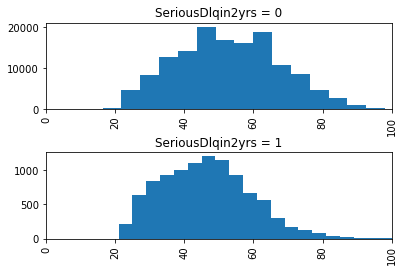

In [77]:
age_hist = data['age'].hist(by=data['SeriousDlqin2yrs'], bins=20, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')
plt.savefig("age_hist.png")

Generally, younger people were more responsbile for defaulting than older people as evident from the 2nd histogram.

In [6]:
data['DebtRatio'].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

In [7]:
np.quantile(data['DebtRatio'],0.975)

3489.024999999994

In [8]:
(data['DebtRatio']>np.quantile(data['DebtRatio'],0.75)+1.5*(np.quantile(data['DebtRatio'],0.75)-np.quantile(data['DebtRatio'],0.25))).sum()

31311

In [9]:
np.quantile(data['DebtRatio'],0.75)+1.5*(np.quantile(data['DebtRatio'],0.75)-np.quantile(data['DebtRatio'],0.25))

1.9080236847499998

2.5% of the persons that is roughly 4 lakh people have debt ratio over 3489. From the figures concerning Debt Ratio, it is evident that there are many outliers. So, it would be prudent to replace values (nearly 20.85) outside 3rd quartile+1.5* IQR=1.908 with that particular value.

The 'NA' values in the 'MonthlyIncome' are repalced by 0 as 'MonthlyIncome' will be 0 in the worst case scenario. This will make our model more robust.

'NA' values in 'NumberofDependents' are replaced by the median of the observations rounded off to the nearest integer as the observations are positively skewed.

We divide the dataset into training set and test set in 80:20 fashion and build our models on the training set and validate our results using the AUC score on the test set.

# Data Preparation

In [10]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")


In [11]:
X_train=train.iloc[:,2:]
X_test=test.iloc[:,3:]
y_train=train["SeriousDlqin2yrs"]
y_test=test["SeriousDlqin2yrs"]

In [12]:
# Random Forest Classifier

In [13]:
grid_param = {
    'n_estimators': [100,300,500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,20,30]
}
classifier=RandomForestClassifier()
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=3)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 500}


In [103]:
rf = RandomForestClassifier(
criterion="gini",
n_estimators=500,     
max_samples=0.8, 
max_depth=30,
max_features='sqrt',    
bootstrap=True,
oob_score=True,
random_state=0
)
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)
print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred_rf))
print("Report : ",
    classification_report(y_test, y_pred_rf))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_rf)

Confusion Matrix:  [[21747  6289]
 [ 1224   740]]
Report :                precision    recall  f1-score   support

           0       0.95      0.78      0.85     28036
           1       0.11      0.38      0.16      1964

    accuracy                           0.75     30000
   macro avg       0.53      0.58      0.51     30000
weighted avg       0.89      0.75      0.81     30000



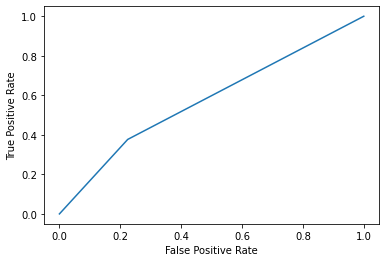

AUC: 0.576231672167789


<Figure size 432x288 with 0 Axes>

In [104]:
#ROC Curve:RandomForest
ordinary_rf=plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = metrics.auc(fpr, tpr)
print("AUC:",roc_auc)

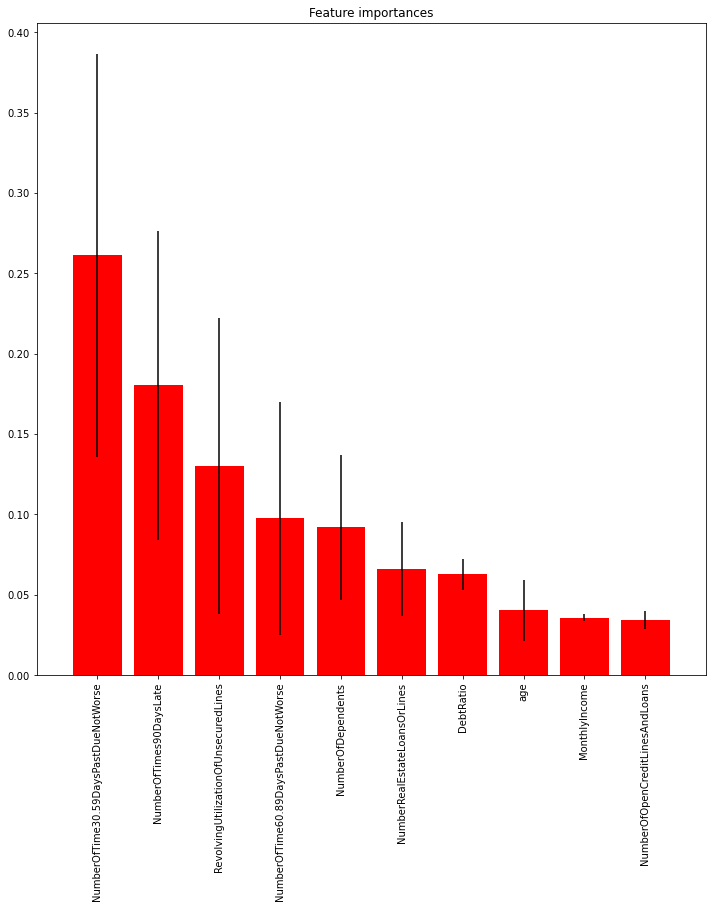

<Figure size 432x288 with 0 Axes>

In [105]:
feat_names = X_train.columns.values
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [106]:
X_train_imp=X_train.iloc[:,[0,2,3,6,7,8,9]]
X_test_imp=X_test.iloc[:,[0,2,3,6,7,8,9]]

In [107]:
rf = RandomForestClassifier(
criterion="gini",
n_estimators=500,     
max_samples=0.8,
max_depth=10,
max_features='sqrt',   
bootstrap=True,
oob_score=True,
random_state=0
)
rf.fit(X_train_imp, y_train)
y_pred_rf_imp=rf.predict(X_test_imp)
print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred_rf_imp))
print("Report : ",
    classification_report(y_test, y_pred_rf_imp))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_rf_imp)

Confusion Matrix:  [[21326  6710]
 [ 1005   959]]
Report :                precision    recall  f1-score   support

           0       0.95      0.76      0.85     28036
           1       0.13      0.49      0.20      1964

    accuracy                           0.74     30000
   macro avg       0.54      0.62      0.52     30000
weighted avg       0.90      0.74      0.80     30000



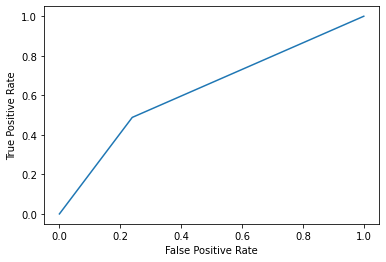

AUC: 0.624477032584524


<Figure size 432x288 with 0 Axes>

In [109]:
#ROC Curve:RandomForest
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = metrics.auc(fpr, tpr)
print("AUC:",roc_auc)

# Logistic Classifier (Optimum Threshold 0.7)

In [110]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.fit_transform(X_test)

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_scaled,y_train)

LogisticRegression(random_state=0)

In [112]:
#Logistic Rgression Model Metrics:
y_pred_log=classifier.predict(X_test_scaled) 
y_pred_proba = (classifier.predict_proba(X_test_scaled)[:,1]>=0.7).astype(int)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred_proba))
print("Report : ",
    classification_report(y_test, y_pred_proba))

Confusion Matrix:  [[22905  5131]
 [  700  1264]]
Report :                precision    recall  f1-score   support

           0       0.97      0.82      0.89     28036
           1       0.20      0.64      0.30      1964

    accuracy                           0.81     30000
   macro avg       0.58      0.73      0.59     30000
weighted avg       0.92      0.81      0.85     30000



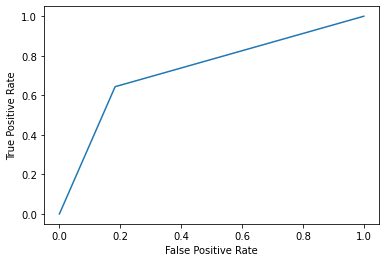

AUC: 0.7302849129966448


<Figure size 432x288 with 0 Axes>

In [113]:
#ROC Curve:Logistic Regression
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = metrics.auc(fpr, tpr)
print("AUC:",roc_auc)

# Decission Tree Classifier

In [24]:
grid_param = {
    'max_depth': [10,20,30],
    'min_samples_leaf': [5,7,9],
    'criterion': ['gini', 'entropy']
}
classifier=DecisionTreeClassifier()
gd_sr = GridSearchCV(estimator=classifier,
                     param_grid=grid_param,
                     scoring='roc_auc',
                     cv=3)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5}


In [37]:
clf_entropy = DecisionTreeClassifier(criterion = "gini",
            random_state =0,max_depth=10, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)
y_pred_entropy=clf_entropy.predict(X_test) 
print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred_entropy))
print("Report : ",
    classification_report(y_test, y_pred_entropy))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_entropy)

Confusion Matrix:  [[21729  6307]
 [ 1195   769]]
Report :                precision    recall  f1-score   support

           0       0.95      0.78      0.85     28036
           1       0.11      0.39      0.17      1964

    accuracy                           0.75     30000
   macro avg       0.53      0.58      0.51     30000
weighted avg       0.89      0.75      0.81     30000



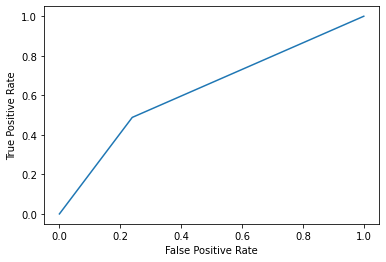

AUC: 0.624477032584524


<Figure size 432x288 with 0 Axes>

In [86]:
#ROC Curve:Decission Tree
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = metrics.auc(fpr, tpr)
print("AUC:",roc_auc)

# KNN Classifier

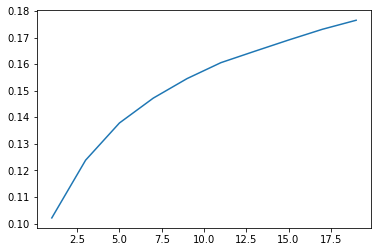

In [87]:
k_list=list(range(1,20,2))
cv_scores=[]
for k in k_list:
    knn=KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,X_train_scaled,y_train,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())    
mse=[1-x for x in cv_scores]
plt.plot(k_list,mse)
best_k=k_list[mse.index(min(mse))]

In [28]:
clf=KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train_scaled,y_train)
y_pred_knn=clf.predict(X_test_scaled)

In [29]:
print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred_knn))
print("Report : ",
    classification_report(y_test, y_pred_knn))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_knn)

Confusion Matrix:  [[19173  8863]
 [  867  1097]]
Report :                precision    recall  f1-score   support

           0       0.96      0.68      0.80     28036
           1       0.11      0.56      0.18      1964

    accuracy                           0.68     30000
   macro avg       0.53      0.62      0.49     30000
weighted avg       0.90      0.68      0.76     30000



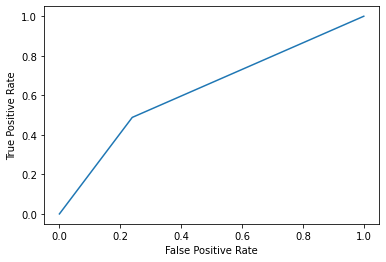

AUC: 0.624477032584524


<Figure size 432x288 with 0 Axes>

In [88]:
#ROC Curve:KNN
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = metrics.auc(fpr, tpr)
print("AUC:",roc_auc)
plt.savefig("knn.png")

# Naive Bayes Classifier:

In [114]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_nb = gnb.predict(X_test)
print("Confusion Matrix: ",
        confusion_matrix(y_test, y_pred_nb))
print("Report : ",
    classification_report(y_test, y_pred_nb))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_nb)

Confusion Matrix:  [[27930   106]
 [ 1834   130]]
Report :                precision    recall  f1-score   support

           0       0.94      1.00      0.97     28036
           1       0.55      0.07      0.12      1964

    accuracy                           0.94     30000
   macro avg       0.74      0.53      0.54     30000
weighted avg       0.91      0.94      0.91     30000



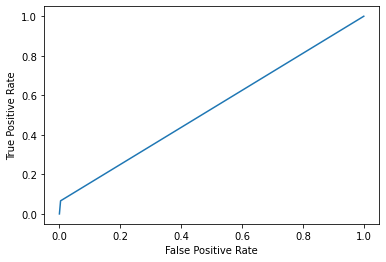

AUC: 0.5312052964198779


In [116]:
#ROC Curve:Naive Bayes
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
roc_auc = metrics.auc(fpr, tpr)
print("AUC:",roc_auc)